In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import shutil
import os
from keras.callbacks import ReduceLROnPlateau

label_csv = './GTZEN/features_30_sec.csv'
audio_fpath = "./GTZEN/genres_original/"

In [2]:
def get_image_path(x):
    splited = x.split('.')
    folder = './GTZEN/images_original/'+splited[0] + '/'
    filename = splited[0]+splited[1]+'.png'
    return folder+filename

def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)
        

In [3]:
df = pd.read_csv(label_csv)

print(df.head())
df.shape

          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516        

(1000, 60)

In [4]:
trainframe = []
for index, row in tqdm(df.iterrows()):
#     if row['filename'] == 'jazz.00054.wav':
#         continue
    i = 0
    
    file_name = os.path.join(os.path.abspath(audio_fpath),str(row['label'] + '/'), str(row['filename']))
    dirname='./prep/' + row['label']
    if not os.path.exists(dirname):
        create_dir(dirname)
    try:
        data, sr = librosa.load(file_name)
    except:
        print(str(row['filename'])+ ' is not a valid file')
    else: 
        
        file_name = os.path.join(os.path.abspath(audio_fpath),str(row['label'] + '/'), str(row['filename']))
        mfcc = []
        length = row['length']/10
        start = 0
        end = length
#         print(str(start) + ' / ' + (str(end)) + ' / ' + str(length))
        while i < 10:
            out_file = dirname+ '/' + row['filename'].split('.wav')[0] + '.' + str(i) + '.png'
            file_name=(out_file.split('/')[-1])
            label=(row['label'])
            trainframe.append([file_name, label])
            if os.path.exists(out_file):
                t = end
                start = end
                end = t + length
                i = i + 1
                continue
            frag = data[int(start):int(end)]
            mfcc = librosa.feature.mfcc(y = frag, sr = sr, n_mfcc=20)
            mfcc = np.subtract(mfcc, np.mean(mfcc))
            mfcc_gram = librosa.amplitude_to_db(mfcc, ref=np.min)
            librosa.display.specshow(mfcc_gram, sr=sr)
            plt.colorbar(format='%+2.0f dB')
            plt.savefig(out_file)
#             plt.show()
            plt.clf()
            t = end
            start = end
            end = t + length
            i = i + 1

524it [00:01, 325.16it/s]C:\Users\Sumit\miniconda3\envs\tf-cuda\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
593it [00:01, 328.28it/s]

jazz.00054.wav is not a valid file


1000it [00:03, 315.84it/s]


In [5]:
np.array(trainframe).shape

(9990, 2)

In [6]:
feature_df = pd.DataFrame(trainframe, columns=['filename','class'])

feature_df.head()

,filename,class
0,blues.00000.0.png,blues
1,blues.00000.1.png,blues
2,blues.00000.2.png,blues
3,blues.00000.3.png,blues
4,blues.00000.4.png,blues


In [7]:
x = np.array(feature_df['filename'].tolist())

x.shape

(9990,)

In [8]:
target = np.array(feature_df['class'].tolist())

In [9]:
y_new = pd.get_dummies(target)
print(y_new.shape)
y_new.head()

(9990, 10)


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [10]:
data = feature_df
data['filename'] = feature_df['filename'].apply(lambda x:x.replace('.wav', '.png'))
data['temp'] = feature_df['class'] +'/' + feature_df['filename'] 
data['path'] = data['temp']
data = data[['filename','path', 'class']]
data.head()

,filename,path,class
0,blues.00000.0.png,blues/blues.00000.0.png,blues
1,blues.00000.1.png,blues/blues.00000.1.png,blues
2,blues.00000.2.png,blues/blues.00000.2.png,blues
3,blues.00000.3.png,blues/blues.00000.3.png,blues
4,blues.00000.4.png,blues/blues.00000.4.png,blues


In [11]:
X_train, X_test = train_test_split(
         data,  test_size=0.1, random_state=15)

print(str(X_train.shape)+ ', ' + str(X_test.shape))
datagen = ImageDataGenerator()
it = datagen.flow_from_dataframe(
    data,
    x_col="path",
    y_col="class",batch_size=1,
    directory='./prep/')

inp = Input(shape = next(it)[0][0].shape)

model = inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    classes=10,
    input_tensor = inp
)

(8991, 3), (999, 3)
Found 9990 validated image filenames belonging to 10 classes.


In [12]:
for layer in model.layers:
    layer.trainable=False

In [13]:
new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation='softmax'))

new_model.compile(loss = 'categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
print(new_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 batch_normalization_94 (Bat  (None, 73728)            294912    
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_95 (Bat  (None, 256)              1024      
 chNormalization)                                       

In [14]:
es = EarlyStopping(
    monitor='val_accuracy', restore_best_weights=True, patience=20, min_delta = 0.001
)
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.5,
                        min_lr=0.00001)
history = new_model.fit(datagen.flow_from_dataframe(
    X_train,
    x_col="path",
    y_col="class",
    batch_size=64, 
    directory = './prep'
),
              validation_data=datagen.flow_from_dataframe(
            X_test,
            x_col="path",
            y_col="class",
            batch_size=100, 
            directory = './prep'),
              epochs=100,
              callbacks=[es])

Found 8991 validated image filenames belonging to 10 classes.
Found 999 validated image filenames belonging to 10 classes.
Epoch 1/100
141/141 [==============================] - 125s 800ms/step - loss: 2.4884 - accuracy: 0.2049 - val_loss: 1.8380 - val_accuracy: 0.3233
Epoch 2/100
141/141 [==============================] - 65s 458ms/step - loss: 2.1390 - accuracy: 0.2669 - val_loss: 1.7479 - val_accuracy: 0.3714
Epoch 3/100
141/141 [==============================] - 65s 458ms/step - loss: 2.0294 - accuracy: 0.2922 - val_loss: 1.7108 - val_accuracy: 0.3984
Epoch 4/100
141/141 [==============================] - 65s 456ms/step - loss: 1.9511 - accuracy: 0.3051 - val_loss: 1.6736 - val_accuracy: 0.3944
Epoch 5/100
141/141 [==============================] - 65s 457ms/step - loss: 1.8790 - accuracy: 0.3239 - val_loss: 1.6443 - val_accuracy: 0.4134
Epoch 6/100
141/141 [==============================] - 65s 457ms/step - loss: 1.7976 - accuracy: 0.3472 - val_loss: 1.6166 - val_accuracy: 0.4154


Text(0, 0.5, 'Accuracy')

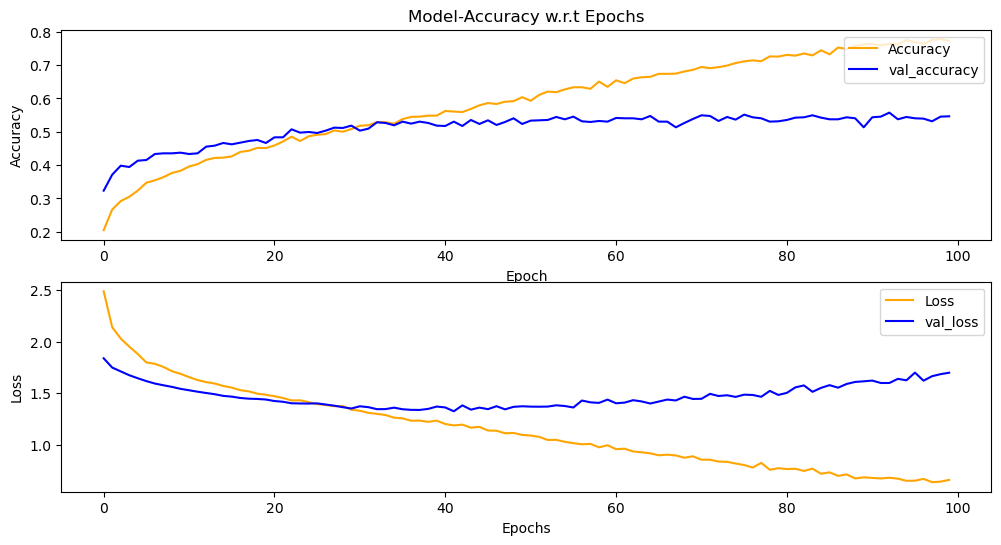

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")